In [185]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter#
import numpy as np

In [135]:
general_dir = '/home/abalzer/Documents/github_clone/bachelor_thesis/pipeline/output/output_20250617_183139_latest_ML'
working_dir = os.path.join(general_dir, 'rna_isoforms')
rna_tissue_file = os.path.join(working_dir, 'transcript_rna_tissue.tsv')
gene_list_file = os.path.join(working_dir, 'gene_list.txt')

In [3]:
def load_gene_list(gene_file):
    with open(gene_file, 'r') as f:
        return set(line.strip() for line in f if line.strip())

def extract_isoform_expression(hpa_file, gene_list):
    # Load the large file in chunks
    chunks = []
    chunk_size = 100_000

    for chunk in pd.read_csv(hpa_file, sep='\t', chunksize=chunk_size):
        # Match by gene name or Ensembl ID
        matched = chunk[chunk['ensgid'].isin(gene_list) ]
        if not matched.empty:
            chunks.append(matched)

    result_df = pd.concat(chunks, ignore_index=True)
    return result_df

In [136]:

gene_list = load_gene_list(gene_list_file)
isoform_df = extract_isoform_expression(rna_tissue_file, gene_list)

isoform_df.to_csv(os.path.join(working_dir, "filtered_isoform_expression.csv"), index=False)
print(f"Saved expression data for {len(isoform_df)} isoforms.")

Saved expression data for 51 isoforms.


In [5]:
wanted_tissues = [
    "Cerebral cortex", "Cerebellum", "Basal ganglia", "Hypothalamus",
    "Midbrain", "Amygdala", "Choroid plexus", "Hippocampal formation",
    "Spinal cord", "Retina", "Thyroid gland", "Parathyroid gland",
    "Adrenal gland", "Pituitary gland", "Lung", "Salivary gland",
    "Esophagus", "Tongue", "Stomach", "Duodenum", "Small intestine",
    "Colon", "Rectum", "Liver", "Gallbladder", "Pancreas", "Kidney",
    "Urinary bladder", "Testis", "Epididymis", "Seminal vesicle",
    "Prostate", "Vagina", "Ovary", "Fallopian tube", "Endometrium",
    "Cervix", "Placenta", "Breast", "Heart muscle", "Smooth muscle",
    "Skeletal muscle", "Adipose tissue", "Skin", "Appendix", "Spleen",
    "Lymph node", "Tonsil", "Bone marrow", "Thymus"
]


In [284]:
!pip install mygene --quiet
import mygene

# Initialize once
mg = mygene.MyGeneInfo()
_id_cache = {}

def get_id(ensgid):
    if ensgid == 'all':
        return 'all'
    if ensgid in _id_cache:
        return _id_cache[ensgid]
    try:
        result = mg.query(ensgid, scopes='ensembl.gene', fields='symbol', species='human', verbose=False)
        gene_symbol = result['hits'][0]['symbol'] if result['hits'] else None
        _id_cache[ensgid] = gene_symbol
        return gene_symbol
    except Exception as e:
        print(f"Error for {ensgid}: {e}")
        return None
def get_human_readable_name(enstid):
    if enstid in _id_cache:
        return _id_cache[enstid]
    try:
        result = mg.query(enstid, scopes='ensembl.transcript', fields='symbol', species='human', verbose=False)
        gene_symbol = result['hits'][0]['symbol'] if result['hits'] else None
        _id_cache[enstid] = gene_symbol
        return gene_symbol
    except Exception as e:
        print(f"Error for {enstid}: {e}")
        return None

In [ ]:
def load_expression_data(filepath):
    return pd.read_csv(filepath)

def filter_gene_isoforms(df, gene_id):
    tpm_cols = [col for col in df.columns if col.startswith("TPM.")]
    gene_df = df[df["ensgid"] == gene_id]
    melted = gene_df[["enstid"] + tpm_cols].melt(id_vars="enstid", var_name="Tissue", value_name="TPM")
    melted["Tissue"] = melted["Tissue"].str.replace("TPM.", "", regex=False)
    melted["Tissue"] = melted["Tissue"].str.replace(r"\.\d+$", "", regex=True)
    melted["Tissue"] = melted["Tissue"].apply(lambda x: x.split(',')[0] if ',' in x else x)
    wanted_tissues_lower = [tissue.lower() for tissue in wanted_tissues]
    melted = melted[melted["Tissue"].isin(wanted_tissues_lower)]
    melted = melted.groupby(["enstid", "Tissue"], as_index=False).mean()
    return melted

def plot_isoforms_heatmap(data, gene_id, working_dir=None, threshold = 0.05, isoform_dict=None, isoform_list=None):
    # Pivot the data for heatmap
    
    data["TPM"] = np.log10(data["TPM"] + 1)  # Log-transform TPM values for better visualization
    data["TPM"] = data.groupby("Tissue")["TPM"].transform(lambda x: (x))  
    # replace nans with 0
    data["TPM"].fillna(0, inplace=True)    

    heatmap_data = data.pivot(index="enstid", columns="Tissue", values="TPM")
    heatmap_data = heatmap_data[heatmap_data.max(axis=1) > threshold]  # Filter out isoforms with max TPM below threshold
    if heatmap_data.empty:
        print(f"No isoforms found for gene {gene_id} with sufficient expression.")
        return []


    # save all isoforms names with a TPM value greater than the threshold 
    isoforms_high_expression = heatmap_data[heatmap_data.max(axis=1) > threshold].index.tolist()
    
    if isoform_list:
        # reorder the heatmap_data according to the isoform_list
        heatmap_data = heatmap_data.loc[isoform_list]
    # Create the heatmap
    g = sns.clustermap(heatmap_data.T, 
                   annot=False, 
                   fmt=".2f", 
                   cmap="PuBuGn", 
                   cbar_kws={'label': 'TPM'}, 
                   linewidths=0.5, 
                   linecolor='gray', 
                   row_cluster=True, col_cluster=False,
                   cbar_pos=(0.85, 0.83, 0.03, 0.15),  # [left, bottom, width, height]
                   xticklabels=True
                   )
    # Set the title and rotate the x-axis labels
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, ha='right')
    g.fig.suptitle(f"Expression of Isoforms for Gene {get_id(gene_id)} ({gene_id})", fontsize=16)
    
    if isoform_dict:
        # add coloring to the x-axis labels based on isoform_dict
        color_dict = {'BTF3': 'darkblue', 'NACA': 'olivedrab', 'NACA2': 'lightgreen', 'NACAD': 'lightcoral','BTF3L4': 'lightblue'}
        for label in g.ax_heatmap.xaxis.get_majorticklabels():
            isoform_name = label.get_text()
            if isoform_name in isoform_dict:
                # Get the gene name from the list
                gene_name = isoform_dict[isoform_name]
            # Set color based on the  gene name
            if gene_name in color_dict:
                label.set_color(color_dict[gene_name])
            else:
                label.set_color('black')

        # rearrange the labels according to the gene_dict
        


        # add a legend for the colors
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_dict.values()]
        labels = list(color_dict.keys())
        g.ax_heatmap.legend(handles, labels, title="Gene Names", loc='upper left', bbox_to_anchor=(1,0), fontsize='small')

        
    
    
    
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    # Add human-readable names to the enstid
    output_file = os.path.join(working_dir, f"isoform_expression_{get_id(gene_id)}_threshold:_{threshold}.png")
    if output_file:
        plt.savefig(output_file, dpi=300)
    return isoforms_high_expression


Processing gene: NACA2 (ENSG00000253506)


/tmp/ipykernel_40227/3391330175.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TPM"].fillna(0, inplace=True)


Processing gene: NACAD (ENSG00000136274)


/tmp/ipykernel_40227/3391330175.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TPM"].fillna(0, inplace=True)


Processing gene: BTF3 (ENSG00000145741)


/tmp/ipykernel_40227/3391330175.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TPM"].fillna(0, inplace=True)


Processing gene: BTF3L4 (ENSG00000134717)


/tmp/ipykernel_40227/3391330175.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TPM"].fillna(0, inplace=True)


Processing gene: NACA (ENSG00000196531)


/tmp/ipykernel_40227/3391330175.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TPM"].fillna(0, inplace=True)


Plotting heatmap for all isoforms combined...
               enstid           Tissue        TPM
0     ENST00000521764   adipose tissue   0.151916
1     ENST00000521764    adrenal gland   0.523116
2     ENST00000521764         amygdala   0.012210
3     ENST00000521764         appendix   0.767465
4     ENST00000521764      bone marrow   0.163751
...               ...              ...        ...
1882  ENST00000679092           thymus   4.437997
1883  ENST00000679092    thyroid gland  13.093460
1884  ENST00000679092           tongue   0.186480
1885  ENST00000679092           tonsil   7.758594
1886  ENST00000679092  urinary bladder   5.862935

[1887 rows x 3 columns]


/tmp/ipykernel_40227/3391330175.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["TPM"].fillna(0, inplace=True)


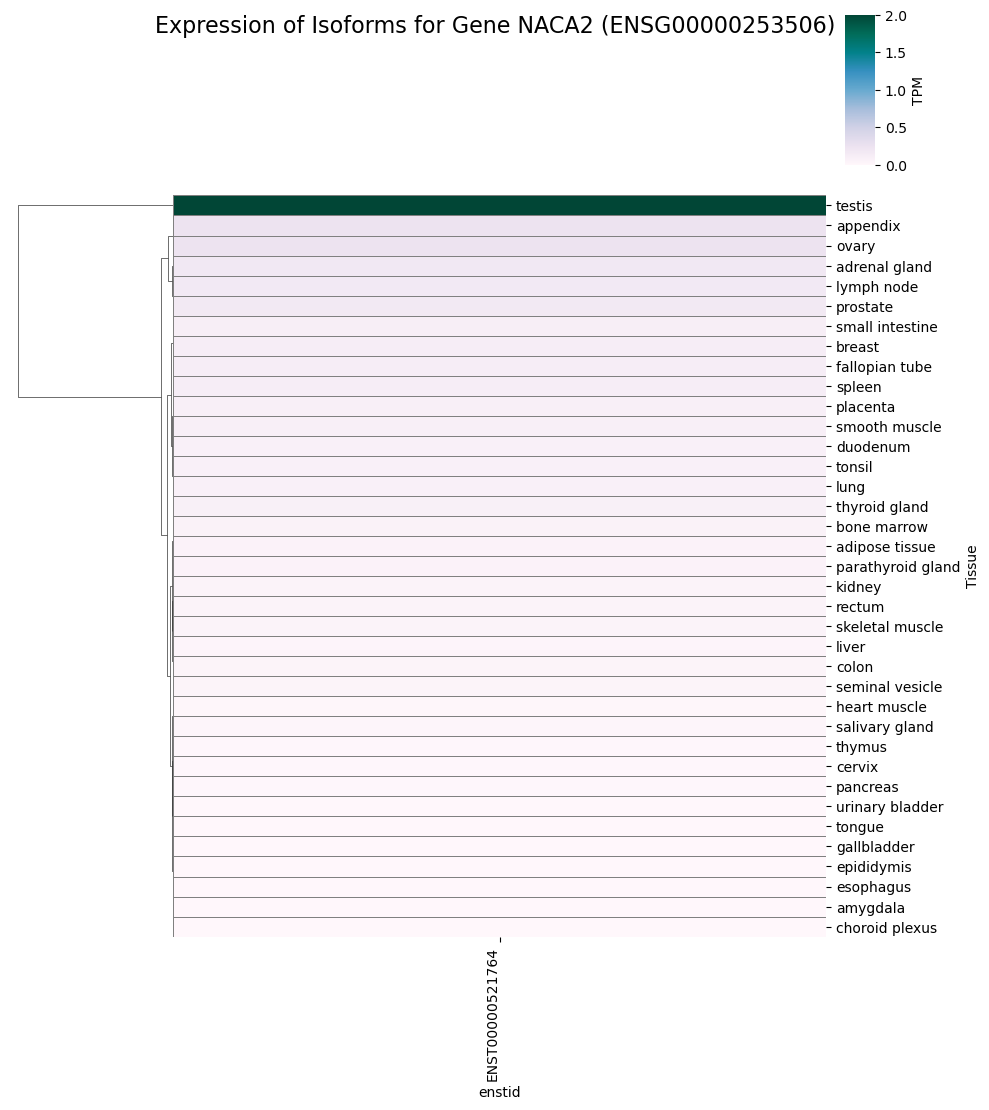

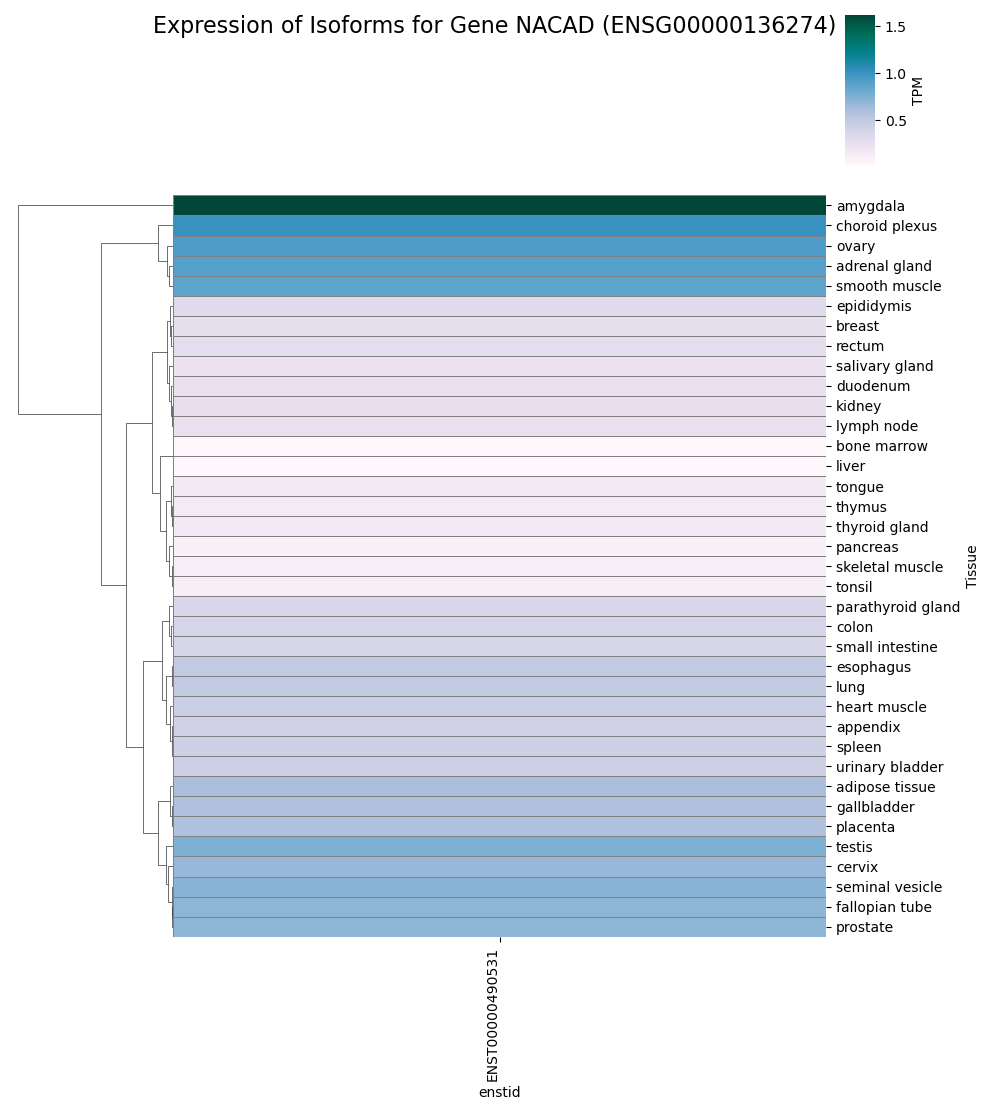

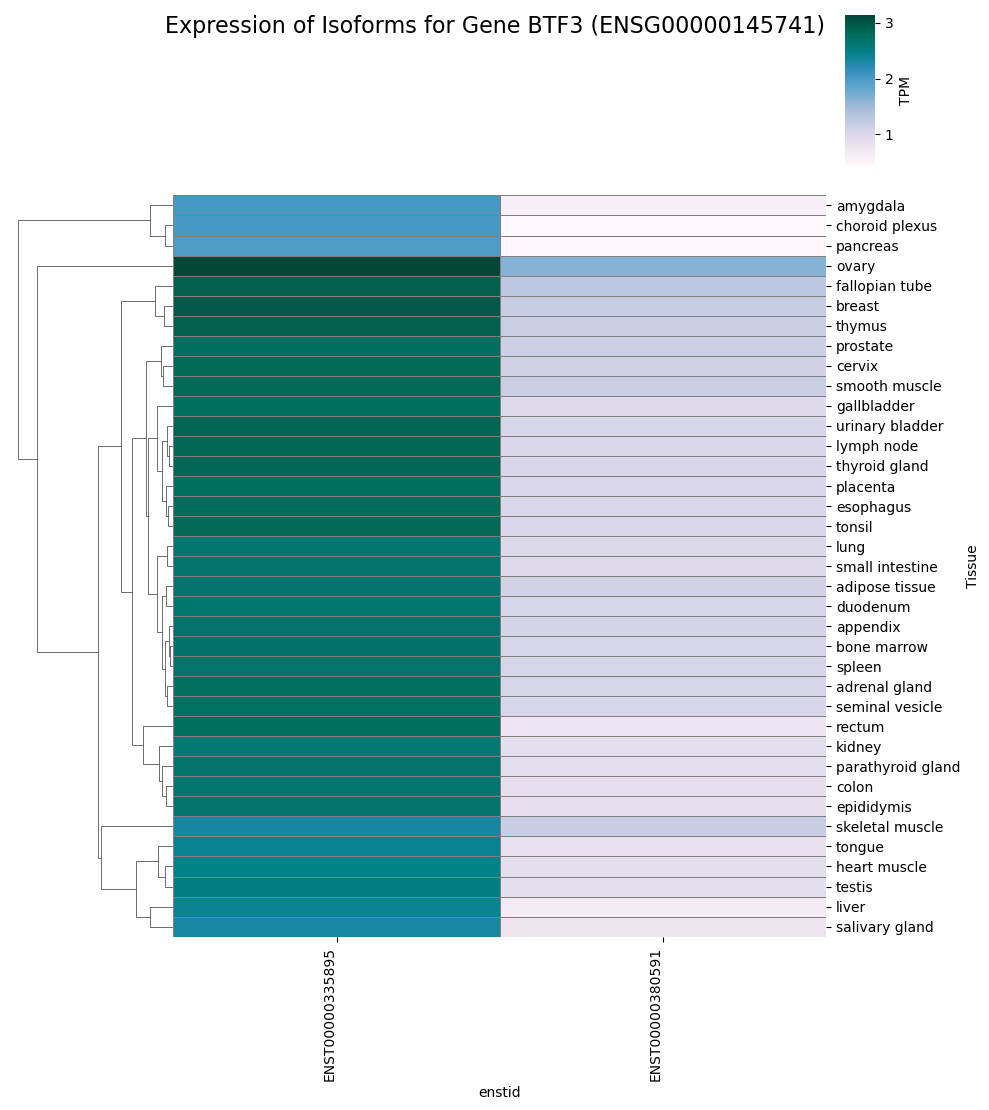

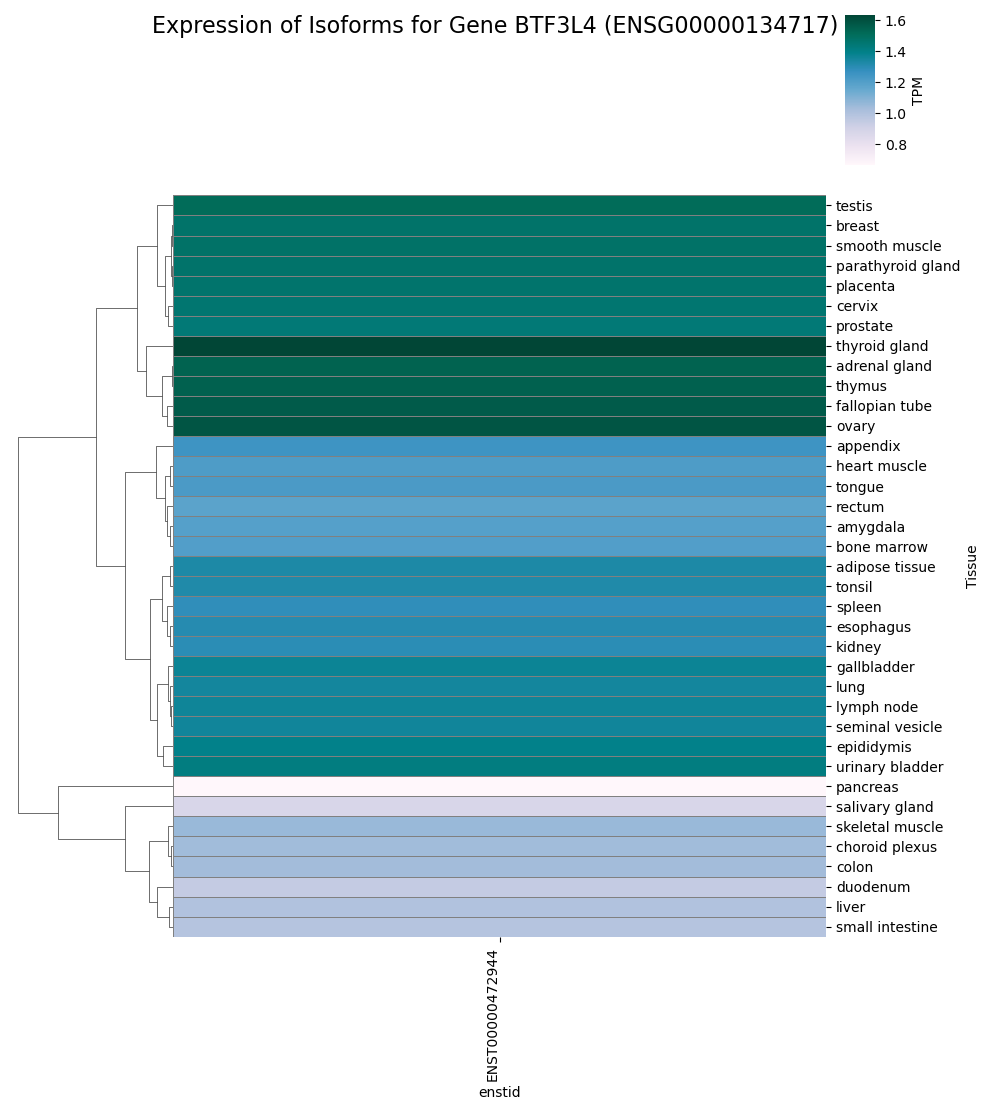

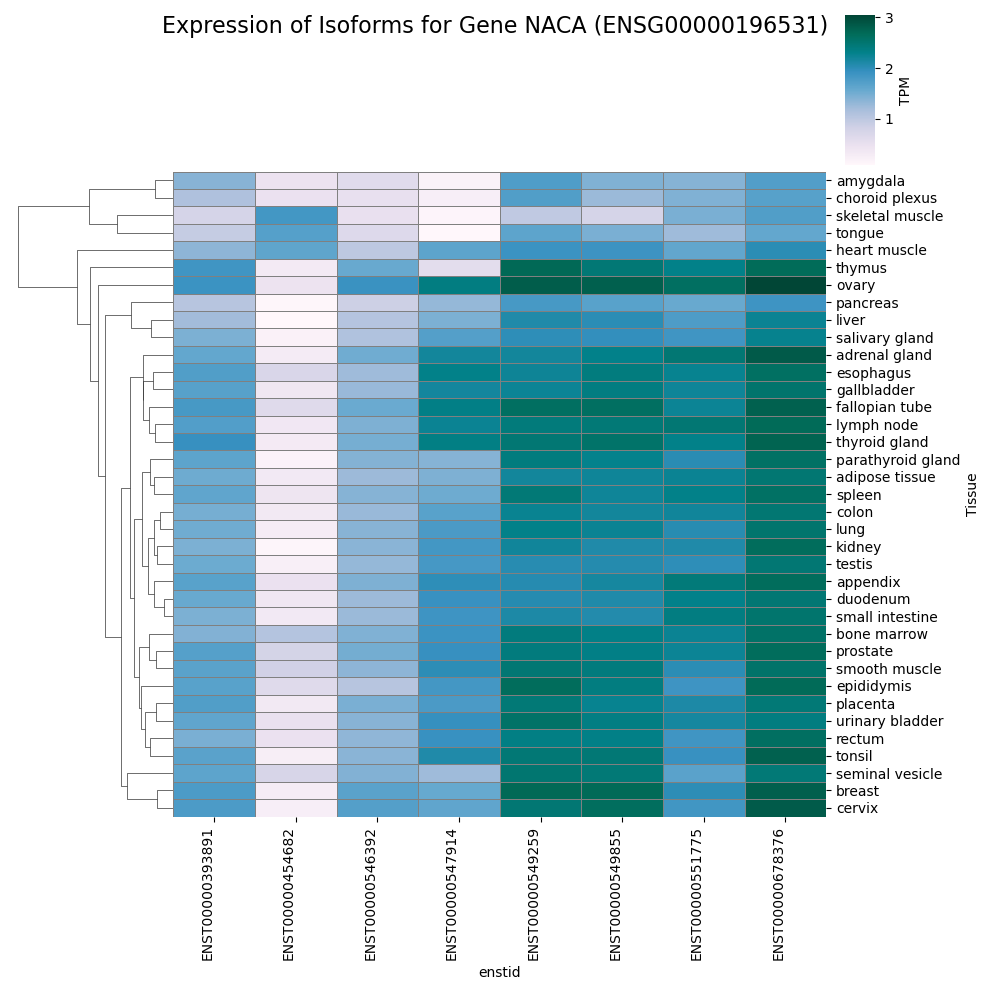

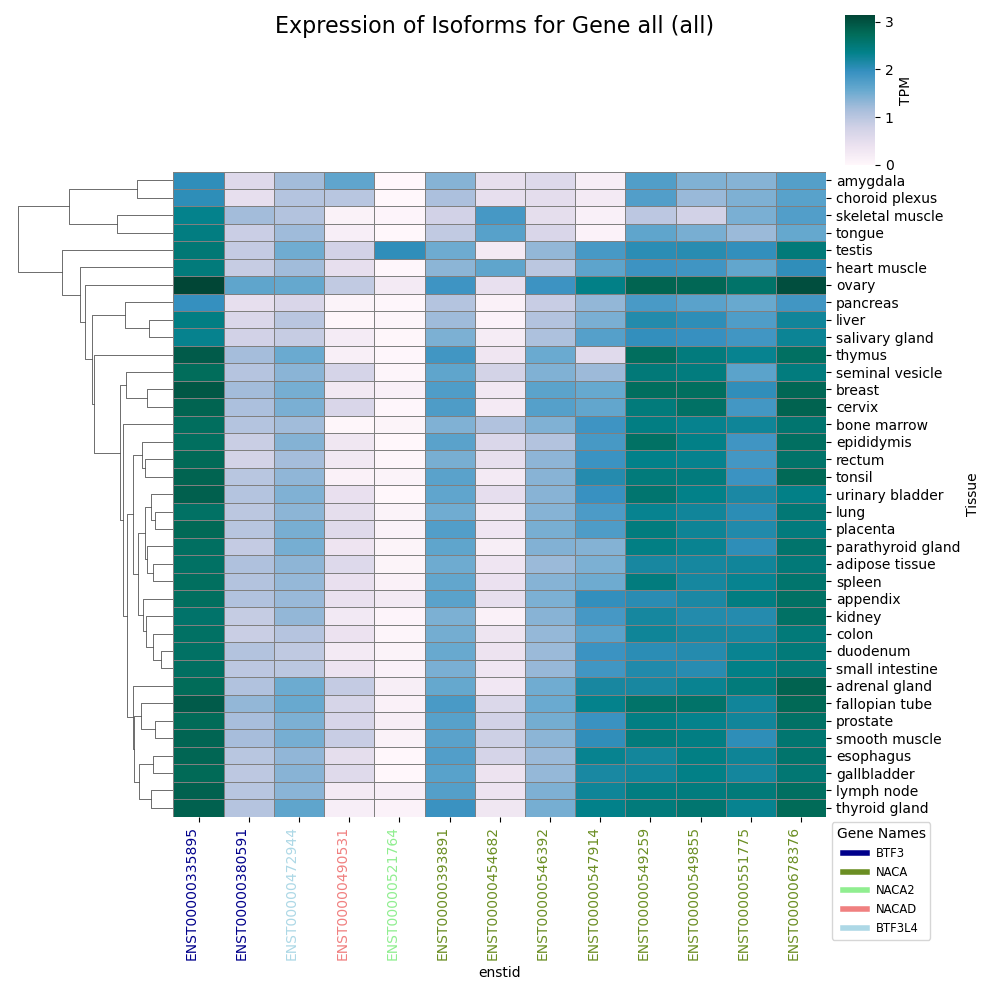

In [307]:
expression_data = load_expression_data(os.path.join(working_dir, "filtered_isoform_expression.csv"))
#gene_id = "ENSG00000136274"
all_isoforms = pd.DataFrame()
isoform_dict = {}
gene_dict = {}
isoform_list = []
for gene_id in gene_list:
    print(f"Processing gene: {get_id(gene_id)} ({gene_id})")
    isoform_data = filter_gene_isoforms(expression_data, gene_id)
    all_isoforms = pd.concat([all_isoforms, isoform_data], ignore_index=True)
    isoforms_high_expression = plot_isoforms_heatmap(isoform_data, 
                                                     gene_id, working_dir=working_dir, 
                                                     threshold=1.6)
    for isoform in isoforms_high_expression:
        if isoform not in isoform_dict:
            isoform_dict[isoform] = get_id(gene_id)
            gene_dict[gene_id] = get_id(gene_id)
    # save isoforms_high_expression
    if isoforms_high_expression:
        output_dir = os.path.join(working_dir, "isoforms_high_expression")
        os.makedirs(output_dir, exist_ok=True)
        with open(os.path.join(output_dir, f"isoforms_high_expression_{get_id(gene_id)}.txt"), 'w') as f:
            for isoform in isoforms_high_expression:
                f.write(f"{isoform}\n")
        isoform_list.extend(isoforms_high_expression)

isoform_list_dir = os.path.join(working_dir, "isoform_list.txt")
isoform_list = pd.read_csv(isoform_list_dir, header=None).squeeze().tolist()
# Plot heatmap for all isoforms combined
print("Plotting heatmap for all isoforms combined...")
print(all_isoforms)
_ = plot_isoforms_heatmap(all_isoforms,
                      gene_id='all', working_dir=working_dir,
                      threshold=1.6, isoform_dict=isoform_dict, isoform_list=isoform_list)

In [ ]:
def fetch_protein_sequence_from_transcript(transcript_id):
    import requests
    
    """
    Fetches the amino acid sequence for a given Ensembl transcript ID (e.g., ENST00000380152).
    
    Args:
        transcript_id (str): Ensembl transcript ID
    
    Returns:
        str: Amino acid sequence or None if not found
    """
    # Step 1: Get translation ID (protein ID) from transcript
    lookup_url = f"https://rest.ensembl.org/lookup/id/{transcript_id}?expand=1"
    headers = {"Content-Type": "application/json"}

    response = requests.get(lookup_url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to retrieve transcript info. Status code: {response.status_code}")
        return None

    data = response.json()
    translation = data.get("Translation") or data.get("translation")
    if not translation or "id" not in translation:
        print(f"No protein translation found for transcript {transcript_id}.")
        return None

    protein_id = translation["id"]

    # Step 2: Fetch protein sequence
    seq_url = f"https://rest.ensembl.org/sequence/id/{protein_id}?type=protein"
    response = requests.get(seq_url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to retrieve protein sequence. Status code: {response.status_code}")
        return None
    print(response.json().get("seq"))
    return response.json().get("seq")

def get_isoform_sequence_and_align(isoform_ids):
    from Bio import pairwise2
    from Bio.pairwise2 import format_alignment
    sequences = []
    for isoform_id in isoform_ids:
        try:
            sequence = fetch_protein_sequence_from_transcript(isoform_id)
            if sequence:
                sequences.append(sequence)
            else:
                print(f"No sequence found for {isoform_id}.")
        except Exception as e:
            print(f"Error fetching sequence for {isoform_id}: {e}")
    # identfiy the longest sequence
    if not sequences:
        print("No sequences found for alignment.")
        return None
    longest_sequence = max(sequences, key=len)
    aligned_sequences = [longest_sequence]  # Start with the longest sequence
    for seq in sequences:
        if seq != longest_sequence:
            # Align the sequence to the longest one using pairwise2
            alignments = pairwise2.align.globalxx(longest_sequence, seq)
            aligned_seq = format_alignment(*alignments[0]).split('\n')[0]
            aligned_sequences.append(aligned_seq)
    # Join aligned sequences with newlines
    aligned_str = "\n".join(aligned_sequences)
    return aligned_str
    


In [ ]:
print(isoforms_high_expression)
aligned_str = get_isoform_sequence_and_align(isoforms_high_expression)
if aligned_str:
    print(f"Aligned sequences for {get_id(gene_id)} ({gene_id}):\n{aligned_str}")
else:
    print(f"No aligned sequences found for {get_id(gene_id)} ({gene_id}).")
# save the aligned sequences to a file
if aligned_str:
    with open(os.path.join(working_dir, f"aligned_sequences_{get_id(gene_id)}.txt"), 'w') as f:
        f.write(aligned_str)
    print(f"Aligned sequences saved for {get_id(gene_id)} ({gene_id}).")
else:
    print(f"No aligned sequences to save for {get_id(gene_id)} ({gene_id}).")
print(f"Aligned sequences saved for {get_id(gene_id)} ({gene_id}).")
print("-" * 80)